[*********************100%***********************]  1 of 1 completed


5081
5081
Index(['Volume', 'MACD_HIST', 'Target'], dtype='object', name='Price')
                            OLS Regression Results                            
Dep. Variable:                 Target   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.336
Date:                Fri, 12 Dec 2025   Prob (F-statistic):              0.263
Time:                        20:55:00   Log-Likelihood:                -1990.0
No. Observations:                5080   AIC:                             3986.
Df Residuals:                    5077   BIC:                             4006.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

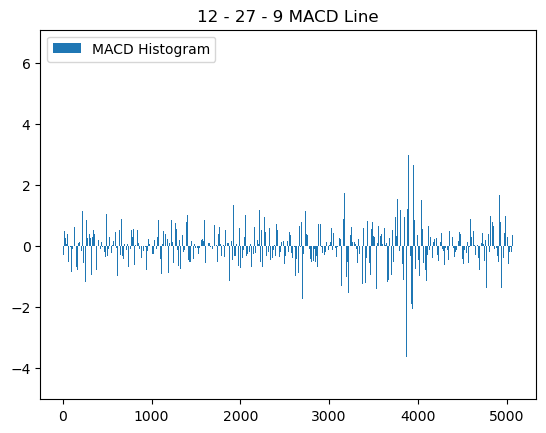

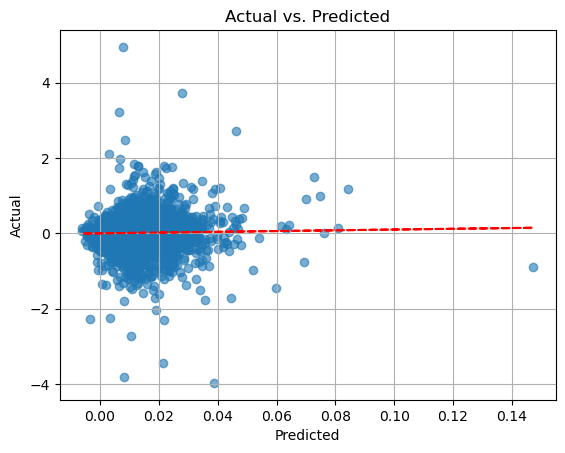


[Overall Model Significance] p-value = 0.262933


Price,Close,High,Low,Open,Volume,Target,12_ema,27_ema,MACD,Signal,MACD_HIST,Predictions,Residuals
0,399.415009,400.119995,398.399994,399.359985,14909537,-1.013988,399.415009,399.415009,0.000000,0.000000,0.000000,0.019912,-1.033900
1,395.364990,399.450012,394.950012,399.440002,15867740,-0.416068,397.221249,397.314999,-0.093750,-0.052084,-0.041667,0.021475,-0.437543
2,393.720001,395.359985,393.510010,395.359985,11281553,-0.099082,395.854711,396.026846,-0.172135,-0.101285,-0.070850,0.015098,-0.114180
3,393.329895,394.100006,392.529999,393.709991,10470999,0.101725,395.057725,395.275914,-0.218189,-0.140887,-0.077302,0.013977,0.087748
4,393.730011,394.059998,393.040009,393.329987,7965634,-0.230744,394.696990,394.919300,-0.222309,-0.165108,-0.057201,0.010320,-0.241064
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5076,681.270020,685.609985,679.700012,683.750000,22746495,0.027889,685.623404,685.133783,0.489621,0.829389,-0.339768,0.032687,-0.004798
5077,681.460022,683.020020,679.174377,681.270020,11918381,0.355117,684.982884,684.871371,0.111512,0.685813,-0.574301,0.018430,0.336687
5078,683.880005,684.340027,680.945007,681.440002,8285257,-0.351674,684.813210,684.800560,0.012650,0.551181,-0.538531,0.013095,-0.364769
5079,681.474976,683.900024,681.210022,683.880005,9756825,0.088784,684.299635,684.563018,-0.263383,0.388268,-0.651651,0.015731,0.073053


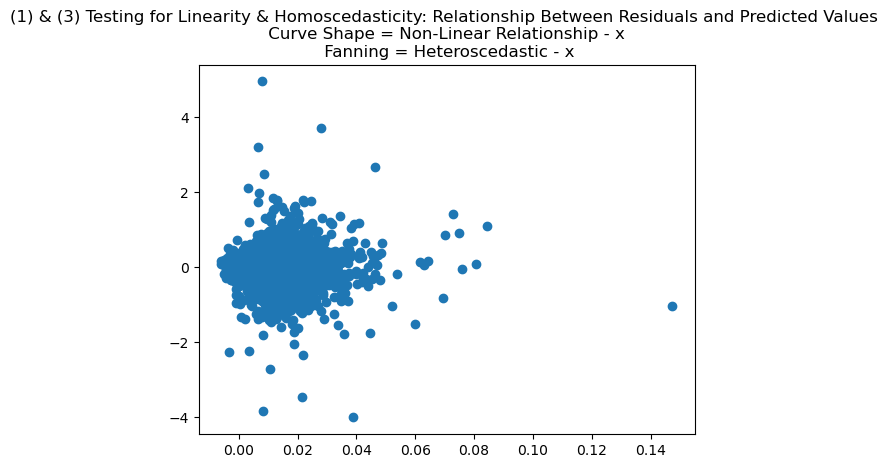

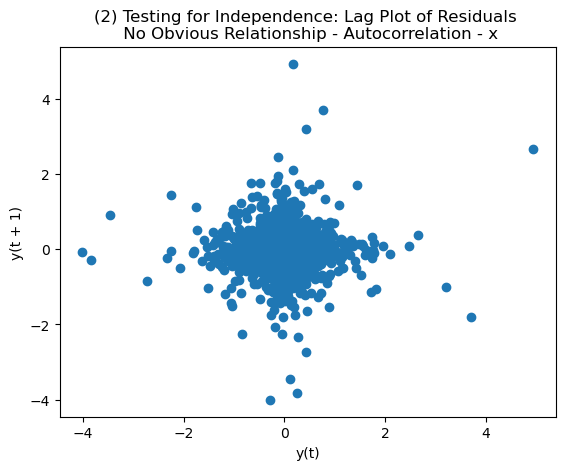

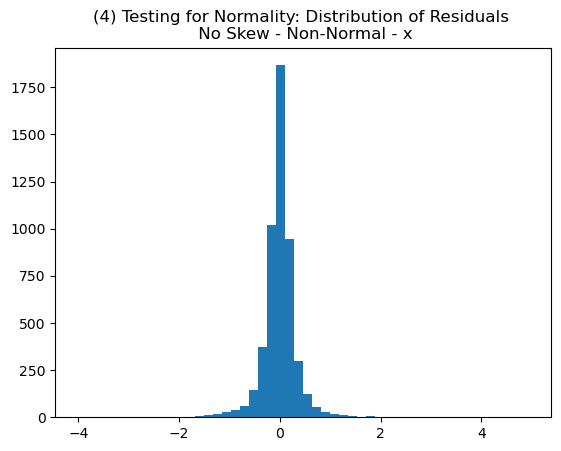

In [3]:
# Switching from SciKit Learn Lib to Stats Models Lib for cleaner results

import numpy as np 
import pandas as pd
from pandas.plotting import lag_plot
import yfinance as yf
import matplotlib.pyplot as plt
    # p-Value is better acessible in this library 
import statsmodels.api as sm

# --- (0) GLOBALEN PARAMETERS ---

# Schritt 1: Ticker
TICKER = "SPY"

# Schritt 2: Preisverhalten 
INTERVAL = "1h"
if INTERVAL == "1h":
    PERIOD = "730d"
else: 
    PERIOD = "max"

# Schritt 3: Strategie/Unabhängige Variable (FGV)
STRATEGY = ["Volume", "MACD_HIST"]
# FVG is bullshit, so we do not use it 
# Step 3: MACD
MACD_FAST = 12
MACD_SLOW = 27
MACD_SPAN = 9

# Schritt 4: Verschieben von Reihen in der Vergangenheit
SHIFT = 1

# Schritt 5: Datenteilmenge (Wie viele Zeilen werden wir analysieren)
LOOKBACK = 10000

# --- (1) Daten herunterladen in df ---

def get_data(ticker = TICKER, interval = INTERVAL, lookback = LOOKBACK):

    # Step 1: Daten herunterladen
    df = yf.download(ticker, interval = interval, period = PERIOD)

    # Step 2: Nur Level 0 of Multilevel Columns selecten
    df.columns = df.columns.get_level_values(0)

    # Step 3: df for Plots vereinfachen (Index statt Datum)
    df = df.reset_index(drop=True)

    # Step 4: Nur LOOKBACK Reihen zurückgeben
    return df.iloc[-lookback:, :]

# --- (2) Abhängige Variable ("Target") definieren ---

def add_target(df, shift = SHIFT):

    # Schritt 1: Delta/Preisverhalten definieren (Morgen - Heute), in percentage Terms * 100
    df["Target"] = (df["Close"].shift(-shift) - df["Close"])/df["Close"] * 100

    # Step 2: df zurückgeben 
    return df

# --- (3) Unabhängige Variablen ("Features") definieren ---

def add_MACD(df, fast = MACD_FAST, slow = MACD_SLOW, span = MACD_SPAN):

    # Step 1: Fast and Slow EMA Columns
    df[f"{fast}_ema"] = df["Close"].ewm(span = fast).mean()
    df[f"{slow}_ema"] = df["Close"].ewm(span = slow).mean()

    # Step 2: MACD Column (= Difference betwenn fast and slow ema)
    df["MACD"] = df[f"{fast}_ema"] - df[f"{slow}_ema"]

    # Step 3: MACD Signal (= Span Period)
    df["Signal"] = df[f"MACD"].ewm(span = span).mean()

    # Step 4: MACD Hist
    df["MACD_HIST"] = df[f"MACD"] - df["Signal"]

    # Step 5: Plot Histogram
    plt.figure()
    plt.bar(x=range(len(df)), height=df["MACD_HIST"])
        # Every Bar = Every Date in the Index
        # Direction: Bar (>0) --> Bullish vs. Bar (<0) --> Bearish
        # Strength: Bar (Tall) --> Strong Momentum vs. Bar (Short) --> Weak Momentum
    plt.title(f"{MACD_FAST} - {MACD_SLOW} - {MACD_SPAN} MACD Line")
    plt.legend(["MACD Histogram"])

    return df

# --- (3) Solve for Autocrrelation Function ---

def fix_autocorrelation(df, interval=SHIFT):
    #print the nr of rows we had initially:
    print(len(df))
    df = df.iloc[::interval].reset_index(drop=True)
    #print the nr of rows we had afterwards:
    print(len(df))
    return df 

# --- (4) Unabhängige Variablen ("Features") definieren ---
def generate_regression_output(df, features=STRATEGY, target="Target"):
    # Step 1: Subset Data. Wählt die Feature- und Target-Spalte aus und entfernt alle Zeilen mit fehlenden Werten (NaN).
    subset = df[features + [target]].dropna()
    print(subset.columns) # Should include all from STRATEGY + target

    # Step 2: Reshape Data and Extract Variables
    # X wird als DataFrame extrahiert, y als Series.
    X = subset[features] 
    y = subset[target] 

    # Step 3: Model Setup (Statsmodels)
    # Fügt eine Konstante (Intercept) zur X-Variable hinzu, da OLS dies separat benötigt.
    X_with_const = sm.add_constant(X)
    
    # Definiert das OLS-Modell (Ordinary Least Squares) und führt die Regression durch (.fit()).
    model = sm.OLS(y, X_with_const).fit() 

    # Step 4: Extract Results
    # Extrahieren des Intercepts (Konstante)
    intercept = model.params['const']
    # Extrahieren der Koeffizienten-Serie (ohne den Intercept)
    coefficients = model.params.drop('const')
    # Extrahieren des R-Squared Wertes
    r2 = model.rsquared
    # Extrahieren der P-Werte (ohne den Intercept)
    p_values = model.pvalues.drop('const')
    # Extrahieren des P-Wertes für das gesamte Modell
    model_p_value = model.f_pvalue # overall model significance
    # Zählt die Beobachtungen
    n_obs = len(subset)
    
    # Generiert die vorhergesagten Werte (Y-Predicted) mit der gelernten Formel.
    y_pred = model.predict(X_with_const) 

    # --- Console summary
    print(model.summary())
    
    # Plot actual vs predicted
    plt.figure()
    # Scatter Plot: Predicted Values (x) vs. Actual Values (y)
    plt.scatter(y_pred, y, alpha=0.6)
    # Zeichnet die ideale 45-Grad-Regressionslinie (y=x) zur visuellen Überprüfung
    plt.plot(y_pred, y_pred, color='red', linestyle='--')
    
    # Beschriftung und Titel
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Actual vs. Predicted")
    plt.grid(True)
    plt.show() # Fügen Sie plt.show hinzu, um die Grafik anzuzeigen

    # Gibt den unveränderten DataFrame (df) und die wichtigsten Ergebnisse zurück.
    return df, intercept, coefficients, model_p_value

# --- (5) VALIDIERUNG DES REGRESSIONSMODELLS ---

def validate_regression_output(df, coef, intercept):
    # Berechnung der Vorhersage und des Fehlers (Residuals)
    df["Predictions"] = intercept
    for feature in coef.index:
        df['Predictions'] += df[feature] * coef[feature] 

    df['Residuals'] = df["Target"] - df["Predictions"]
    # Positive Residuen bedeuten, dass das Modell zu pessimistisch war (zu niedrig vorhergesagt hat).

    # Plot 1: Linearität & Homoskedastizität (Voraussetzung für die Regression)
    # Scatter Plot: Predicted Values vs. Residuals (Fehler).
    plt.figure()
    plt.scatter(df['Predictions'], df['Residuals'])
    # Curve Shape = Non-Linear Relationship (x) | Fanning = Heteroscedastic (x)
    plt.title('(1) & (3) Testing for Linearity & Homoscedasticity: Relationship Between Residuals and Predicted Values \n Curve Shape = Non-Linear Relationship - x \n Fanning = Heteroscedastic - x')
    
    # Plot 2: Autokorrelation (Unabhängigkeit der Fehler)
    # Lag Plot: Fehler heute vs. Fehler gestern. Sollte keine offensichtliche Struktur zeigen.
    plt.figure()
    lag_plot(df['Residuals'].dropna()) 
    plt.title('(2) Testing for Independence: Lag Plot of Residuals \n No Obvious Relationship - Autocorrelation - x')

    # Plot 3: Normalität der Residuals (Glockenkurvenform)
    # Histogram: Zeigt die Verteilung der Fehler. Sollte annähernd normalverteilt sein.
    plt.figure()
    plt.hist(df['Residuals'], bins=50)
    plt.title('(4) Testing for Normality: Distribution of Residuals \n No Skew - Non-Normal - x') 

    return df

# --- HAUPT-EXECUTION (MAIN) ---

def main():
    # Annahme: Diese Schritte laden und bereiten die Daten vor
    df = get_data()
    df = add_target(df) 
    df = add_MACD(df)
    df = fix_autocorrelation(df)
    # Regression durchführen und Ergebnisse zuweisen
    # Annahme: generate_regression_output gibt df, intercept und coefficient zurück.
    df, fit_intercept, fit_coefficient, model_pval = generate_regression_output(df) 
    # 1. Statistische Validierung der Regression (visuell)
    df = validate_regression_output(df, coef=fit_coefficient, intercept=fit_intercept) 
    
    print(f"\n[Overall Model Significance] p-value = {model_pval:.6f}")

    return df

df = main()
df